<a href="https://colab.research.google.com/github/EC-Arpita/Emotion_detection_RAVDESS/blob/main/Emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
import shutil

In [ ]:
# Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
zip_path = '/content/drive/My Drive/ravdess/Actors_zip file.zip'
local_dir = '/content/ravdess/'
local_zip_path = os.path.join(local_dir, 'Actors_zip file.zip')

# Check if the destination directory exists, and create it if it doesn't
if not os.path.exists(local_dir):
    os.makedirs(local_dir)
    print(f"Created directory: {local_dir}")
else:
    print(f"Directory already exists: {local_dir}")

# Now, copy the file
try:
    shutil.copyfile(zip_path, local_zip_path)
    print(f"Successfully copied file to: {local_zip_path}")
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please make sure the source file path is correct and your Google Drive is mounted.")

# Unzip the file and continue with your data processing
!unzip "{local_zip_path}" -d "{local_dir}"


  inflating: /content/ravdess/Actor_20/03-01-06-01-01-01-20.wav  
  inflating: /content/ravdess/Actor_20/03-01-06-01-01-02-20.wav  
  inflating: /content/ravdess/Actor_20/03-01-06-01-02-01-20.wav  
  inflating: /content/ravdess/Actor_20/03-01-06-01-02-02-20.wav  
  inflating: /content/ravdess/Actor_20/03-01-06-02-01-01-20.wav  
  inflating: /content/ravdess/Actor_20/03-01-06-02-01-02-20.wav  
  inflating: /content/ravdess/Actor_20/03-01-06-02-02-01-20.wav  
  inflating: /content/ravdess/Actor_20/03-01-06-02-02-02-20.wav  
  inflating: /content/ravdess/Actor_20/03-01-07-01-01-01-20.wav  
  inflating: /content/ravdess/Actor_20/03-01-07-01-01-02-20.wav  
  inflating: /content/ravdess/Actor_20/03-01-07-01-02-01-20.wav  
  inflating: /content/ravdess/Actor_20/03-01-07-01-02-02-20.wav  
  inflating: /content/ravdess/Actor_20/03-01-07-02-01-01-20.wav  
  inflating: /content/ravdess/Actor_20/03-01-07-02-01-02-20.wav  
  inflating: /content/ravdess/Actor_20/03-01-07-02-02-01-20.wav  
  inflati

In [ ]:
# Define a dictionary to map the numerical emotion labels to their names
emotion_labels = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

# Create lists to store the file paths and emotion labels
file_path_list = []
emotion_label_list = []

# Loop through all actor directories
ravdess_dir = '/content/ravdess/'
for actor_dir in os.listdir(ravdess_dir):
    # Check if it's a directory
    if os.path.isdir(os.path.join(ravdess_dir, actor_dir)):
        # Loop through each audio file in the actor's directory
        for audio_file in os.listdir(os.path.join(ravdess_dir, actor_dir)):
            if audio_file.endswith('.wav'):
                # Split the filename to get the emotion label
                parts = audio_file.split('-')
                emotion_code = parts[2]

                # Get the emotion name from the dictionary
                if emotion_code in emotion_labels:
                    emotion = emotion_labels[emotion_code]

                    # Get the full file path
                    full_path = os.path.join(ravdess_dir, actor_dir, audio_file)

                    # Append to our lists
                    file_path_list.append(full_path)
                    emotion_label_list.append(emotion)

# Create a Pandas DataFrame
df = pd.DataFrame({
    'file_path': file_path_list,
    'emotion': emotion_label_list
})

# Display the first few rows of the DataFrame
print(df.head())

# Print the number of files and unique emotions to verify
print(f"\nTotal number of files: {len(df)}")
print(f"Unique emotions: {df['emotion'].unique()}")
print(f"Distribution of emotions:\n{df['emotion'].value_counts()}")

                                           file_path    emotion
0  /content/ravdess/Actor_05/03-01-08-01-02-01-05...  surprised
1  /content/ravdess/Actor_05/03-01-05-01-01-01-05...      angry
2  /content/ravdess/Actor_05/03-01-03-01-02-02-05...      happy
3  /content/ravdess/Actor_05/03-01-05-02-01-01-05...      angry
4  /content/ravdess/Actor_05/03-01-03-02-02-01-05...      happy

Total number of files: 1440
Unique emotions: ['surprised' 'angry' 'happy' 'disgust' 'sad' 'calm' 'fearful' 'neutral']
Distribution of emotions:
emotion
surprised    192
angry        192
happy        192
disgust      192
sad          192
calm         192
fearful      192
neutral       96
Name: count, dtype: int64


In [ ]:
# Install librosa
!pip install librosa soundfile

In [ ]:
import numpy as np
import librosa
import soundfile as sf

def preprocess_audio(file_path, augment=False):
    try:
        audio, sr = librosa.load(file_path, sr=None)
        target_sr = 16000
        audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
        audio, _ = librosa.effects.trim(audio, top_db=20)
        audio = (audio - np.mean(audio)) / np.std(audio)

        if augment:
            # Add random noise
            noise = np.random.normal(0, 0.005, audio.shape)
            audio = audio + noise
            # Pitch shift
            audio = librosa.effects.pitch_shift(audio, sr=target_sr, n_steps=np.random.randint(-2, 3))
            # Time stretch
            audio = librosa.effects.time_stretch(audio, rate=np.random.uniform(0.8, 1.2))

        return audio, target_sr
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None, None

In [ ]:
# Create a new directory to store the preprocessed audio files
preprocessed_dir = '/content/preprocessed_ravdess/'
if not os.path.exists(preprocessed_dir):
    os.makedirs(preprocessed_dir)

# Create new lists for the preprocessed file paths and labels
preprocessed_file_path_list = []
preprocessed_emotion_label_list = []

for index, row in df.iterrows():
    # Original audio
    audio, sr = preprocess_audio(row['file_path'], augment=False)
    if audio is not None:
        base_name = os.path.basename(row['file_path'])
        new_file_path = os.path.join(preprocessed_dir, base_name)
        sf.write(new_file_path, audio, sr)
        preprocessed_file_path_list.append(new_file_path)
        preprocessed_emotion_label_list.append(row['emotion'])

        # Augmented audio (e.g., 2 augmented versions per file)
        for i in range(2):
            audio_aug, sr = preprocess_audio(row['file_path'], augment=True)
            if audio_aug is not None:
                aug_file_path = os.path.join(preprocessed_dir, f"aug_{i}_{base_name}")
                sf.write(aug_file_path, audio_aug, sr)
                preprocessed_file_path_list.append(aug_file_path)
                preprocessed_emotion_label_list.append(row['emotion'])

preprocessed_df = pd.DataFrame({
    'file_path': preprocessed_file_path_list,
    'emotion': preprocessed_emotion_label_list
})

# Display the new DataFrame and verify the number of files
print("\nNew DataFrame with preprocessed file paths:")
print(preprocessed_df.head())
print(f"\nTotal preprocessed files: {len(preprocessed_df)}")


New DataFrame with preprocessed file paths:
                                           file_path    emotion
0  /content/preprocessed_ravdess/03-01-08-01-02-0...  surprised
1  /content/preprocessed_ravdess/aug_0_03-01-08-0...  surprised
2  /content/preprocessed_ravdess/aug_1_03-01-08-0...  surprised
3  /content/preprocessed_ravdess/03-01-05-01-01-0...      angry
4  /content/preprocessed_ravdess/aug_0_03-01-05-0...      angry

Total preprocessed files: 4320


In [ ]:
import numpy as np
import librosa
from sklearn.preprocessing import StandardScaler, LabelEncoder

def extract_features_and_prepare_data(preprocessed_df, max_mfcc_length=200, max_mel_length=128):
    """
    Extracts statistical MFCCs for ML and log-Mel-spectrograms for DL, and prepares data for both models.

    Args:
        preprocessed_df (pd.DataFrame): DataFrame with file paths and emotion labels.
        max_mfcc_length (int): Maximum length for MFCCs to pad/truncate.
        max_mel_length (int): Maximum length for Mel-spectrograms to pad/truncate.

    Returns:
        tuple: (mfccs_data, mel_specs_data, encoded_labels, label_encoder)
    """
    mfccs_list = []
    mel_specs_list = []
    labels_list = []

    for index, row in preprocessed_df.iterrows():
        try:
            audio, sr = librosa.load(row['file_path'], sr=16000)

            # MFCCs for Random Forest (ML)
            mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
            delta_mfccs = librosa.feature.delta(mfccs)
            delta2_mfccs = librosa.feature.delta(mfccs, order=2)
            # Compute statistical features (mean and std for MFCCs, delta, delta-delta)
            mfcc_features = np.concatenate([
                np.mean(mfccs, axis=1), np.std(mfccs, axis=1),
                np.mean(delta_mfccs, axis=1), np.std(delta_mfccs, axis=1),
                np.mean(delta2_mfccs, axis=1), np.std(delta2_mfccs, axis=1)
            ])

            # Log-Mel-spectrogram for CNN (DL)
            mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
            mel_spec_db = librosa.util.fix_length(mel_spec_db, size=max_mel_length, axis=1)

            mfccs_list.append(mfcc_features)
            mel_specs_list.append(mel_spec_db)
            labels_list.append(row['emotion'])
        except Exception as e:
            print(f"Error processing {row['file_path']}: {e}")
            continue

    # Convert to numpy arrays
    mfccs_data = np.array(mfccs_list)
    mel_specs_data = np.array(mel_specs_list)
    labels = np.array(labels_list)

    # Scale MFCCs for ML
    scaler = StandardScaler()
    mfccs_data = scaler.fit_transform(mfccs_data)

    # Encode labels
    le = LabelEncoder()
    encoded_labels = le.fit_transform(labels)

    return mfccs_data, mel_specs_data, encoded_labels, le

# Run the data preparation
mfccs_features, mel_spec_features, y_encoded, label_encoder = extract_features_and_prepare_data(preprocessed_df)

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train_mfcc, X_test_mfcc, y_train, y_test = train_test_split(
    mfccs_features, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded)

X_train_mel, X_test_mel, _, _ = train_test_split(
    mel_spec_features, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded)

Visualizing features for a 'happy' audio file: /content/preprocessed_ravdess/03-01-03-02-01-01-23.wav


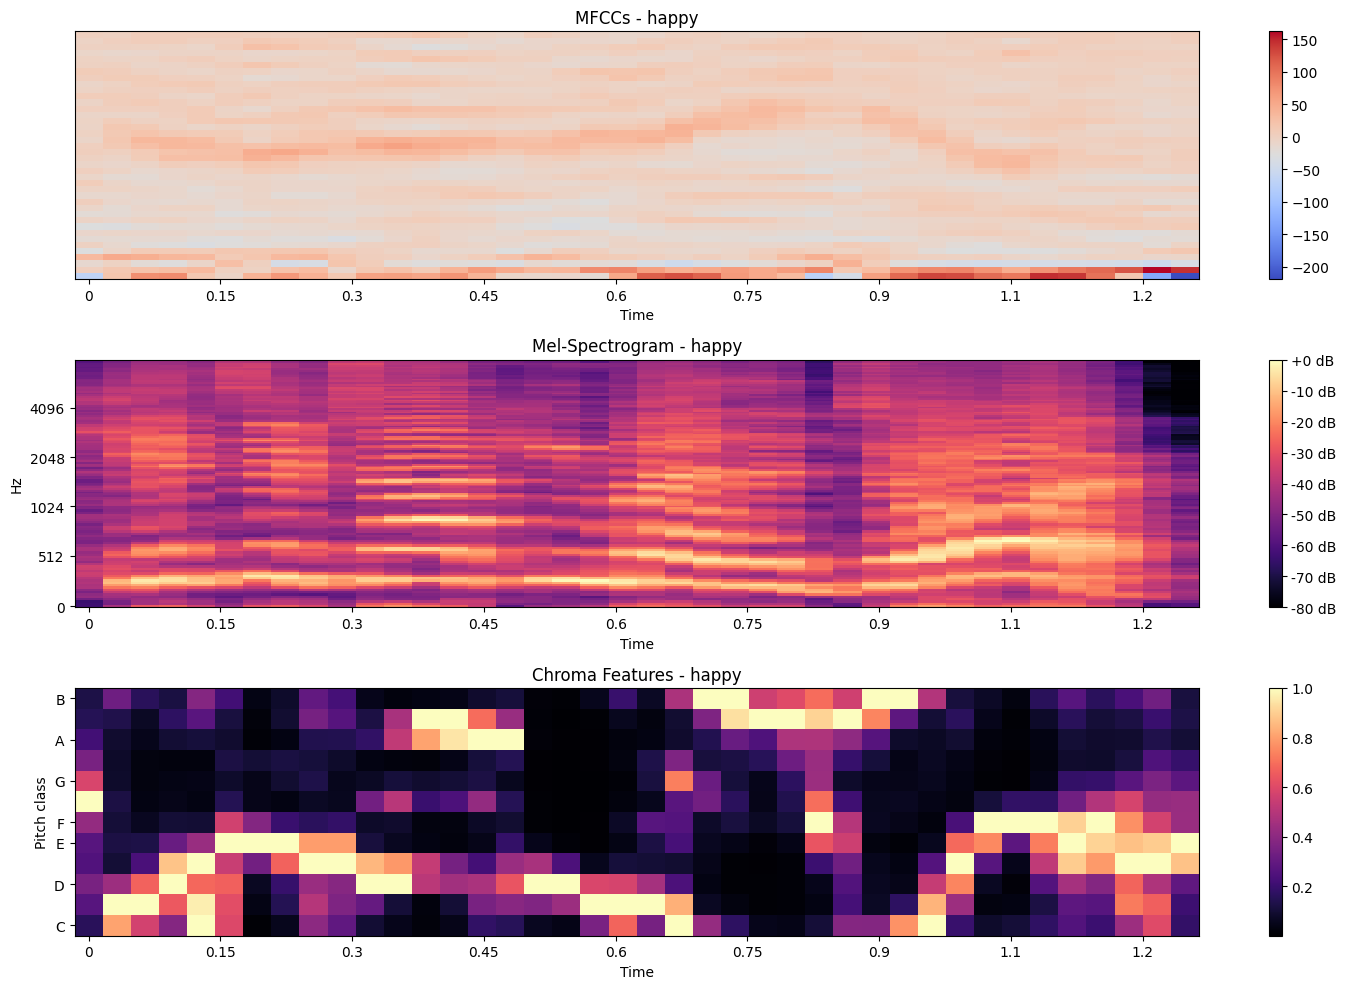

In [ ]:
# Select a random file for visualization
import random
import matplotlib.pyplot as plt

# Get a random index from the preprocessed DataFrame
random_index = random.randint(0, len(preprocessed_df) - 1)
sample_file = preprocessed_df.iloc[random_index]['file_path']
sample_emotion = preprocessed_df.iloc[random_index]['emotion']
print(f"Visualizing features for a '{sample_emotion}' audio file: {sample_file}")

# Load and extract features for the sample file
audio, sr = librosa.load(sample_file, sr=16000)
mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
chroma = librosa.feature.chroma_stft(y=audio, sr=sr)

# Convert Mel-spectrogram to decibels for better visualization
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

# Create a subplot figure for visualization
plt.figure(figsize=(15, 10))

# Plot MFCCs
plt.subplot(3, 1, 1)
librosa.display.specshow(mfccs, x_axis='time', sr=sr)
plt.colorbar()
plt.title(f'MFCCs - {sample_emotion}')
plt.tight_layout()

# Plot Mel-Spectrogram
plt.subplot(3, 1, 2)
librosa.display.specshow(mel_spectrogram_db, x_axis='time', y_axis='mel', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title(f'Mel-Spectrogram - {sample_emotion}')
plt.tight_layout()

# Plot Chroma Features
plt.subplot(3, 1, 3)
librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', sr=sr)
plt.colorbar()
plt.title(f'Chroma Features - {sample_emotion}')
plt.tight_layout()

plt.show()

Model-1 Random Forest on MFCCs

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Compute class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}

# Define parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize Random Forest
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight=class_weight_dict)

# Perform GridSearchCV
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_mfcc, y_train)

# Best model
rf_model = grid_search.best_estimator_
print(f"Best Random Forest Parameters: {grid_search.best_params_}")

# Evaluate
y_pred_rf = rf_model.predict(X_test_mfcc)
print("Random Forest Classifier Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))

Best Random Forest Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Random Forest Classifier Performance:
Accuracy: 0.6852

Classification Report:
              precision    recall  f1-score   support

       angry       0.70      0.76      0.73       144
        calm       0.57      0.91      0.70       144
     disgust       0.69      0.74      0.72       144
     fearful       0.75      0.67      0.71       144
       happy       0.74      0.55      0.63       144
     neutral       0.76      0.36      0.49        72
         sad       0.64      0.51      0.57       144
   surprised       0.76      0.81      0.79       144

    accuracy                           0.69      1080
   macro avg       0.70      0.66      0.67      1080
weighted avg       0.70      0.69      0.68      1080



Model-2 CNN on Mel-spectograms

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Reshape Mel-spectrograms for CNN
X_train_mel = X_train_mel.reshape(X_train_mel.shape[0], X_train_mel.shape[1], X_train_mel.shape[2], 1)
X_test_mel = X_test_mel.reshape(X_test_mel.shape[0], X_test_mel.shape[1], X_test_mel.shape[2], 1)

# One-hot encode labels
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

# Compute class weights for CNN
class_weight_dict_cnn = {i: w for i, w in enumerate(class_weights)}

# Define improved CNN
input_shape = (X_train_mel.shape[1], X_train_mel.shape[2], 1)
num_classes = len(label_encoder.classes_)

cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile model
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Train model
print("\nTraining CNN Model...")
history = cnn_model.fit(
    X_train_mel, y_train_one_hot,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_mel, y_test_one_hot),
    class_weight=class_weight_dict_cnn,
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate
print("\n--- CNN Model Performance ---")
y_pred_cnn_probs = cnn_model.predict(X_test_mel)
y_pred_cnn = np.argmax(y_pred_cnn_probs, axis=1)
y_true_cnn = np.argmax(y_test_one_hot, axis=1)
print(f"Test Accuracy: {cnn_model.evaluate(X_test_mel, y_test_one_hot, verbose=0)[1]:.4f}")
print("\nClassification Report:")
print(classification_report(y_true_cnn, y_pred_cnn, target_names=label_encoder.classes_))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training CNN Model...
Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 272s 3s/step - accuracy: 0.1986 - loss: 2.5993 - val_accuracy: 0.2093 - val_loss: 2.0744 - learning_rate: 0.0010
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.3543 - loss: 1.8052 - val_accuracy: 0.2028 - val_loss: 2.4643 - learning_rate: 0.0010
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.4036 - loss: 1.6572 - val_accuracy: 0.2806 - val_loss: 2.3017 - learning_rate: 0.0010
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.4846 - loss: 1.4446 - val_accuracy: 0.2861 - val_loss: 2.8229 - learning_rate: 0.0010
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 269s 3s/step - accuracy: 0.4959 - loss: 1.3430 - val_accuracy: 0.2639 - val_loss: 4.0819 - learning_rate: 0.0010
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 320s 3s/step - accuracy: 0.5459 - loss: 1.2622 - val_accuracy: 0.4713 - val_loss: 1.6013 - learning_rate: 0.0010
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 316s 3s/step

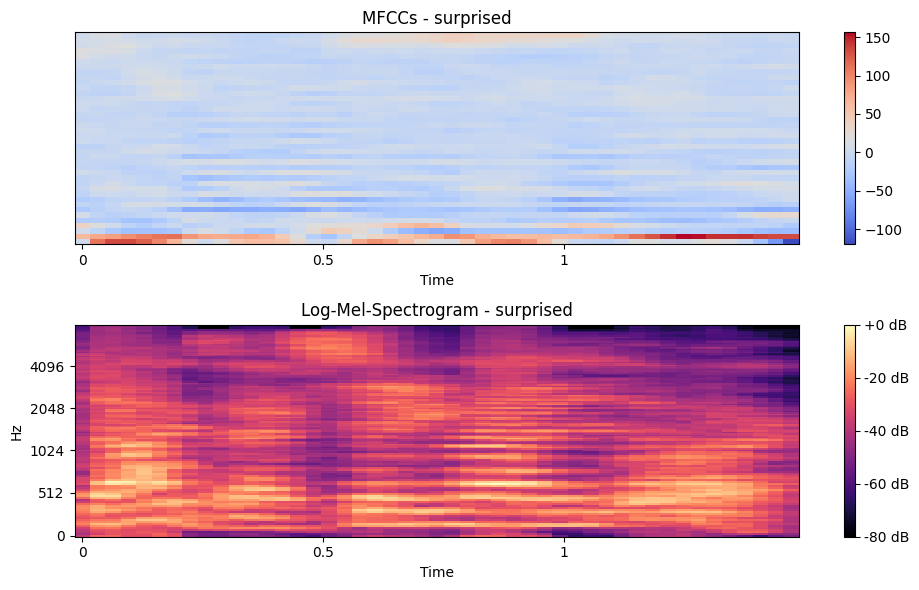

In [ ]:
import matplotlib.pyplot as plt
import librosa.display
import random

def visualize_features(file_path, emotion, sr=16000):
    audio, _ = librosa.load(file_path, sr=sr)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    librosa.display.specshow(mfccs, x_axis='time', sr=sr)
    plt.colorbar()
    plt.title(f'MFCCs - {emotion}')

    plt.subplot(2, 1, 2)
    librosa.display.specshow(mel_spec_db, x_axis='time', y_axis='mel', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Log-Mel-Spectrogram - {emotion}')
    plt.tight_layout()
    plt.show()

random_index = random.randint(0, len(preprocessed_df) - 1)
visualize_features(preprocessed_df.iloc[random_index]['file_path'],
                   preprocessed_df.iloc[random_index]['emotion'])

In [ ]:
# Save the trained CNN model
cnn_model.save('cnn_model.h5')
print("Model saved as cnn_model.h5")

Model saved as cnn_model.h5
